In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from tabulate import tabulate
from helper_functions import helperFunctions, params

In [2]:
hf = helperFunctions("datafile.csv")
df = hf.import_datafile("datafile.csv")
test_df = hf.import_test_datafile("clean_dataset.csv")

In [3]:
df.shape, test_df.shape

((725040, 8), (583200, 9))

In [4]:
df.columns, test_df.columns

(Index(['S0', 'k', 'n', 'm', 'E*', 'm6', 'E', 'S'], dtype='object'),
 Index(['S0', 'k', 'n', 'm', 'E*', 'm6', 'E', 'S', 'Sf'], dtype='object'))

In [5]:
test_df[:240]

,S0,k,n,m,E*,m6,E,S,Sf
0,5,50,0.05,0.001,0.01,-2.0,0.0025,42.152,41.702490
1,5,50,0.05,0.001,0.01,-2.0,0.0050,43.296,42.807291
2,5,50,0.05,0.001,0.01,-2.0,0.0075,44.288,43.389164
3,5,50,0.05,0.001,0.01,-2.0,0.0100,44.859,43.751107
4,5,50,0.05,0.001,0.01,-2.0,0.0125,45.213,43.990441
...,...,...,...,...,...,...,...,...,...
235,5,50,0.05,0.001,0.01,-2.0,0.5900,19.656,19.895158
236,5,50,0.05,0.001,0.01,-2.0,0.5925,19.580,19.824002
237,5,50,0.05,0.001,0.01,-2.0,0.5950,19.507,19.753172
238,5,50,0.05,0.001,0.01,-2.0,0.5975,19.436,19.682669


In [6]:
sorted_df = hf.processDfIntoMaterials(df)

In [7]:
sorted_df.shape

(2430, 246)

In [8]:
sorted_df.head(6)

,0.0025,0.005,0.0075,0.01,0.0125,0.015,0.0175,0.02,0.0225,0.025,...,0.5925,0.595,0.5975,0.6,E*,S0,k,n,m,m6
curve_index,,,,,,,,,,,,,,,,,,,,,
927,42.152,43.296,44.288,44.859,45.213,45.718,46.011,46.265,46.357,46.365,...,19.580,19.507,19.436,19.382,0.01,5,50,0.05,0.001,-2.0
1985,42.118,43.608,44.528,44.992,45.485,45.794,46.045,46.118,46.238,46.216,...,20.424,20.351,20.279,20.206,0.10,5,50,0.05,0.001,-2.0
3006,42.289,43.956,44.750,44.972,45.064,45.576,45.866,45.992,46.053,46.113,...,21.750,21.671,21.592,21.514,0.50,5,50,0.05,0.001,-2.0
926,42.261,44.666,45.750,45.841,46.079,46.616,46.869,46.895,46.925,46.853,...,29.701,29.625,29.575,29.508,0.01,5,50,0.05,0.001,-1.2
1984,42.209,43.547,44.405,45.045,45.573,46.062,46.530,46.818,46.886,47.174,...,24.784,24.971,25.000,26.047,0.10,5,50,0.05,0.001,-1.2
3005,42.256,44.936,45.515,45.724,45.966,46.503,46.513,46.493,46.733,46.591,...,24.560,23.837,24.289,23.741,0.50,5,50,0.05,0.001,-1.2


In [9]:
def optimise_law_materials(df_material, p = True):
    
    error_at_each_step = []
    def callback_func(params):
        error = hf.material_viscoplastic_law_error(params, sigma_exp_material)
        error_at_each_step.append(error)
    
    # Initialize parameters
    params_init = np.array([50, 0.4, 0.001, -2, 5])  # Initial guess for k, n, m, m6, sigma0

    sigma_exp_material = df_material.drop(["S0", "k", "n", "m", "m6", "E*"], axis = 1).values

    # Perform gradient descent using SciPy's minimize function
    result = minimize(hf.material_viscoplastic_law_error, params_init, args=(sigma_exp_material), method='L-BFGS-B', callback=callback_func)

    # Extract optimal parameters
    optimal_params = result.x
    k_opt, n_opt, m_opt, m6_opt, sigma0_opt = optimal_params
    



    if p == True:
        for epsilon_dot, sigma_exp in zip(hf.DEFAULT_STRAIN_RATES, sigma_exp_material):
            # plt.plot(error_at_each_step)

            k = df_material.iloc[0]["k"]
            n = df_material.iloc[0]["n"]
            m = df_material.iloc[0]["m"]
            m6 = df_material.iloc[0]["m6"]
            sigma0 = df_material.iloc[0]["S0"]

            # Round the optimal parameters to 2 decimal places
            k_opt_rounded = round(k_opt, 2)
            n_opt_rounded = round(n_opt, 2)
            m_opt_rounded = round(m_opt, 2)
            m6_opt_rounded = round(m6_opt, 2)
            sigma0_opt_rounded = round(sigma0_opt, 2)
            error = hf.viscoplastic_law_error((k, n, m, m6, sigma0), hf.DEFAULT_EPS_ARRAY, epsilon_dot, sigma_exp)
            error_opt_rounded = round(error_at_each_step[-1], 5)



            # Define data as a list of tuples
            data = [
                ("Final Error", error_opt_rounded, error),
                ("k", k_opt_rounded, k),
                ("n", n_opt_rounded, n),
                ("m", m_opt_rounded, m),
                ("m6", m6_opt_rounded, m6),
                ("sigma0", sigma0_opt_rounded, sigma0)
            ]

            # Print as a table
            table = tabulate(data, headers=["Parameter", "Optimal Value", "Real Value"], tablefmt="grid")
        print(table)

    opt_params = params(sigma0_opt, k_opt, n_opt, m_opt, m6_opt)

    return opt_params


In [10]:
def testMaterial(index):
    df_material = sorted_df.iloc[index*3:index*3+3]
    opt_params = optimise_law_materials(df_material)
    hf.validate_material(df_material, opt_params)

+-------------+-----------------+--------------+
| Parameter   |   Optimal Value |   Real Value |
+=============+=================+==============+
| Final Error |         0.07165 |      14.8795 |
+-------------+-----------------+--------------+
| k           |       210.92    |     200      |
+-------------+-----------------+--------------+
| n           |         0.81    |       0.8    |
+-------------+-----------------+--------------+
| m           |         0.2     |       0.2    |
+-------------+-----------------+--------------+
| m6          |        -0.02    |       0      |
+-------------+-----------------+--------------+
| sigma0      |       301.72    |     300      |
+-------------+-----------------+--------------+


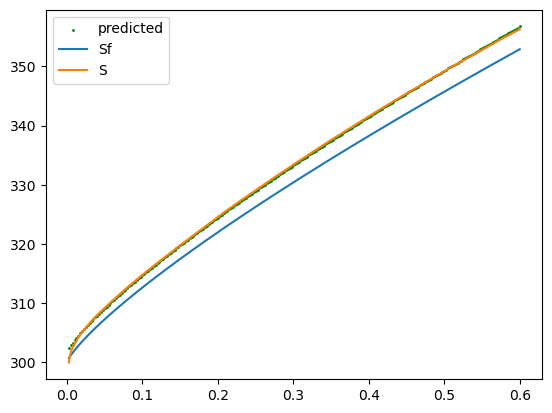

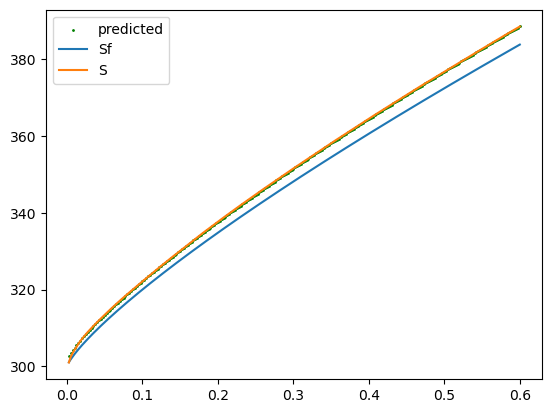

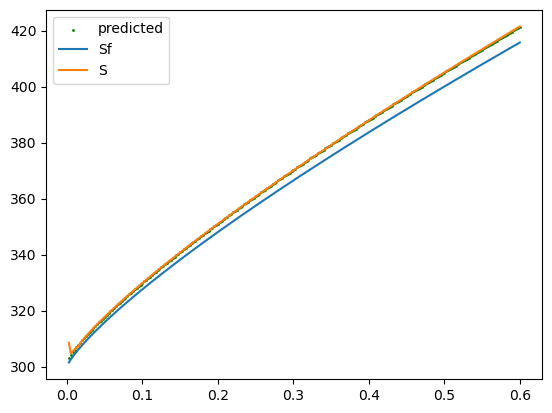

In [12]:
testMaterial(784)

In [16]:
def compute_curves(sorted_df):
    total_iterations = len(sorted_df) // 3
    results = []
    for i in range(total_iterations):
        df_material = sorted_df[3 * i: 3 * (i+1)]
        opt_params = optimise_law_materials(df_material, p = False)
        
        row1 = df_material.iloc[0]   
        stress_data = df_material.drop(hf.param_list + ["E*"], axis = 1)
        
        error_opt = hf.material_viscoplastic_law_error((opt_params.k, opt_params.n, opt_params.m, opt_params.m6, opt_params.s0), stress_data.values)
        

        error = 0
        for index, epsilon_dot in enumerate(hf.DEFAULT_STRAIN_RATES):
            e = hf.viscoplastic_law_error((row1["k"], row1["n"], row1["m"], row1["m6"], row1["S0"]), hf.DEFAULT_EPS_ARRAY, epsilon_dot, stress_data.iloc[index])
            error += e

        results.append({
            'k_opt': opt_params.k,
            'n_opt': opt_params.n,
            'm_opt': opt_params.m,
            'm6_opt': opt_params.m6,
            's0_opt': opt_params.s0,
            'error_opt': error_opt,
            'k_real': row1["k"],
            'n_real': row1["n"],
            'm_real': row1["m"],
            'm6_real': row1["m6"],
            's0_real': row1["S0"],
            'error': error/3
        })
        
        # Print progress
        progress_percent = (i + 1) / total_iterations * 100
        print(f"Processed {i + 1}/{total_iterations} ({progress_percent:.2f}%)", end="\r")


    return pd.DataFrame(results)

In [18]:
results = compute_curves(sorted_df)

C:\Users\dunzu\Documents\Project\ML-for-Material-Behaviour\helper_functions.py:52: RuntimeWarning: overflow encountered in square
  return np.mean((np.array(sigma_pred) - np.array(sigma_exp))**2)
C:\Users\dunzu\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


C:\Users\dunzu\Documents\Project\ML-for-Material-Behaviour\helper_functions.py:52: RuntimeWarning: overflow encountered in square
  return np.mean((np.array(sigma_pred) - np.array(sigma_exp))**2)
C:\Users\dunzu\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


C:\Users\dunzu\Documents\Project\ML-for-Material-Behaviour\helper_functions.py:52: RuntimeWarning: overflow encountered in square
  return np.mean((np.array(sigma_pred) - np.array(sigma_exp))**2)
C:\Users\dunzu\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


C:\Users\dunzu\Documents\Project\ML-for-Material-Behaviour\helper_functions.py:52: RuntimeWarning: overflow encountered in square
  return np.mean((np.array(sigma_pred) - np.array(sigma_exp))**2)
C:\Users\dunzu\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\dunzu\Documents\Project\ML-for-Material-Behaviour\helper_functions.py:52: RuntimeWarning: overflow encountered in square
  return np.mean((np.array(sigma_pred) - np.array(sigma_exp))**2)
C:\Users\dunzu\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\dunzu\Documents\Project\ML-for-Material-Behaviour\helper_functions.py:52: RuntimeWarning: overflow encountered in square
  return np.mean((np.array(sigma_pred) - np.array(sigma_exp))**2)
C:\Users\dunzu\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered

C:\Users\dunzu\Documents\Project\ML-for-Material-Behaviour\helper_functions.py:52: RuntimeWarning: overflow encountered in square
  return np.mean((np.array(sigma_pred) - np.array(sigma_exp))**2)
C:\Users\dunzu\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\dunzu\Documents\Project\ML-for-Material-Behaviour\helper_functions.py:52: RuntimeWarning: overflow encountered in square
  return np.mean((np.array(sigma_pred) - np.array(sigma_exp))**2)
C:\Users\dunzu\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


C:\Users\dunzu\Documents\Project\ML-for-Material-Behaviour\helper_functions.py:52: RuntimeWarning: overflow encountered in square
  return np.mean((np.array(sigma_pred) - np.array(sigma_exp))**2)
C:\Users\dunzu\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\dunzu\Documents\Project\ML-for-Material-Behaviour\helper_functions.py:52: RuntimeWarning: overflow encountered in square
  return np.mean((np.array(sigma_pred) - np.array(sigma_exp))**2)
C:\Users\dunzu\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


C:\Users\dunzu\Documents\Project\ML-for-Material-Behaviour\helper_functions.py:52: RuntimeWarning: overflow encountered in square
  return np.mean((np.array(sigma_pred) - np.array(sigma_exp))**2)
C:\Users\dunzu\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


C:\Users\dunzu\Documents\Project\ML-for-Material-Behaviour\helper_functions.py:52: RuntimeWarning: overflow encountered in square
  return np.mean((np.array(sigma_pred) - np.array(sigma_exp))**2)
C:\Users\dunzu\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


C:\Users\dunzu\Documents\Project\ML-for-Material-Behaviour\helper_functions.py:52: RuntimeWarning: overflow encountered in square
  return np.mean((np.array(sigma_pred) - np.array(sigma_exp))**2)
C:\Users\dunzu\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


C:\Users\dunzu\Documents\Project\ML-for-Material-Behaviour\helper_functions.py:36: RuntimeWarning: overflow encountered in scalar power
  sigma_pred = sigma0 + k * epsilon**n * epsilon_dot**m * np.exp(m6*epsilon)
C:\Users\dunzu\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\dunzu\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\dunzu\Documents\Project\ML-for-Material-Behaviour\helper_functions.py:36: RuntimeWarning: overflow encountered in scalar power
  sigma_pred = sigma0 + k * epsilon**n * epsilon_dot**m * np.exp(m6*epsilon)
C:\Users\dunzu\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\dunzu\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarn

In [19]:
results.to_csv("materialParameterPredictions.csv")

In [20]:
results

,k_opt,n_opt,m_opt,m6_opt,s0_opt,error_opt,k_real,n_real,m_real,m6_real,s0_real,error
0,52.010581,0.063377,0.005422,-2.244002,7.687145,0.190499,50.0,0.05,0.001,-2.0,5.0,1.874842
1,811.750048,0.002154,-0.000744,-0.059426,-758.858317,1.259547,50.0,0.05,0.001,-1.2,5.0,4.345438
2,52.197987,0.067221,-0.003118,-0.840726,7.171477,0.142580,50.0,0.05,0.001,-0.6,5.0,1.347442
3,51.291643,0.056560,0.000520,-0.393871,6.392160,0.043667,50.0,0.05,0.001,-0.3,5.0,1.101728
4,53.135991,0.059725,0.089742,-2.090844,5.908933,0.012830,50.0,0.05,0.090,-2.0,5.0,2.003808
...,...,...,...,...,...,...,...,...,...,...,...,...
805,279.882554,0.067984,0.000386,0.713615,96.598731,8.815439,300.0,0.80,0.001,0.0,300.0,18.850751
806,278.256626,0.065960,0.003685,0.711560,97.951995,9.172496,300.0,0.80,0.010,0.0,300.0,18.755860
807,279.323490,0.059714,0.017124,0.677157,97.870803,13.384765,300.0,0.80,0.050,0.0,300.0,17.945170
808,277.828301,0.053976,0.028835,0.650831,99.495335,24.680383,300.0,0.80,0.090,0.0,300.0,17.256840


In [21]:
results.describe()

,k_opt,n_opt,m_opt,m6_opt,s0_opt,error_opt,k_real,n_real,m_real,m6_real,s0_real,error
count,810.000000,810.000000,810.000000,810.000000,810.000000,808.000000,810.000000,810.000000,810.000000,810.000000,810.000000,808.000000
mean,159.169714,0.213295,0.046626,-0.459255,31.069284,1388.351824,107.950617,0.366914,0.075414,-0.500864,102.024691,4.586421
std,176.093414,0.195871,0.110042,0.796658,171.729818,11511.371237,68.184999,0.221198,0.070213,0.675484,112.175804,6.527004
min,41.893792,0.000988,-0.626795,-3.068614,-2143.124207,0.000453,50.000000,0.050000,0.001000,-2.000000,5.000000,0.065564
25%,81.625460,0.053101,0.002882,-0.878483,18.602124,0.038423,80.000000,0.100000,0.010000,-0.600000,20.000000,1.259646
50%,99.720925,0.104978,0.031300,-0.097176,27.698071,0.198242,90.000000,0.400000,0.050000,-0.300000,25.000000,2.913466
75%,207.384706,0.398728,0.088879,0.087844,87.567747,0.794317,100.000000,0.500000,0.090000,0.000000,200.000000,5.391644
max,2247.723707,0.814246,0.277997,0.732183,302.660187,164874.555430,300.000000,0.800000,0.200000,0.000000,300.000000,92.357166


In [22]:
np.argmax(results["error_opt"])

785

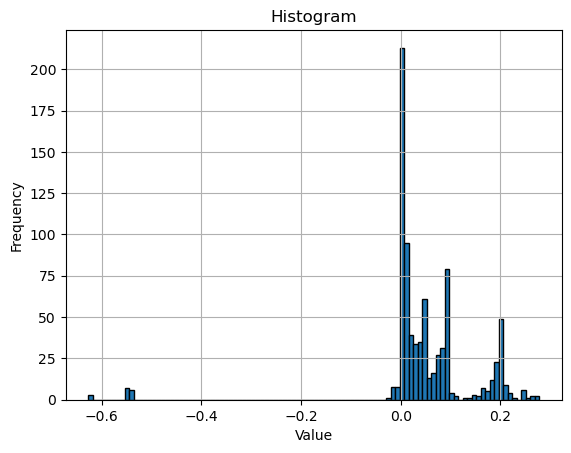

In [19]:

plt.hist(results.m_opt, bins=100, edgecolor='black')
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [20]:
results.loc[(results["error_opt"] > 10) & (results["error_opt"] < 2000)]

,k_opt,n_opt,m_opt,m6_opt,s0_opt,error_opt,k_real,n_real,m_real,m6_real,s0_real,error
385,82.061387,0.116412,-0.002999,-0.711775,34.006530,14.948851,90.0,0.1,0.001,-0.6,25.0,15.443952
639,169.358547,0.036234,0.036786,0.271287,71.971104,10.376531,100.0,0.6,0.200,0.0,200.0,4.836174
644,158.602257,0.021270,0.029906,0.343124,66.972585,10.806101,100.0,0.8,0.200,0.0,200.0,4.907451
729,244.596926,0.021021,0.022298,0.163735,93.006396,10.347913,90.0,0.6,0.200,0.0,300.0,6.376489
734,233.578022,0.010949,0.018239,0.212323,89.350545,10.180371,90.0,0.8,0.200,0.0,300.0,6.472123
749,254.449036,0.028224,0.027381,0.148396,96.788091,11.374727,100.0,0.5,0.200,0.0,300.0,6.808843
759,235.463069,0.012130,0.020042,0.235071,89.696845,12.325022,100.0,0.8,0.200,0.0,300.0,6.974940
769,310.131000,0.062748,0.056051,0.197396,115.035781,28.298493,200.0,0.4,0.200,0.0,300.0,11.352253
773,299.135883,0.067096,0.027662,0.303669,108.233550,11.738453,200.0,0.5,0.090,0.0,300.0,12.226765
774,294.196103,0.055844,0.050312,0.266203,108.651640,33.906962,200.0,0.5,0.200,0.0,300.0,11.467255


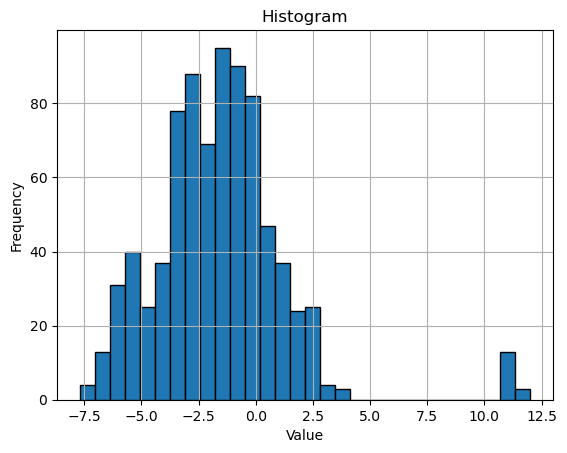

In [21]:

plt.hist(np.log(results.error_opt), bins=30, edgecolor='black')
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


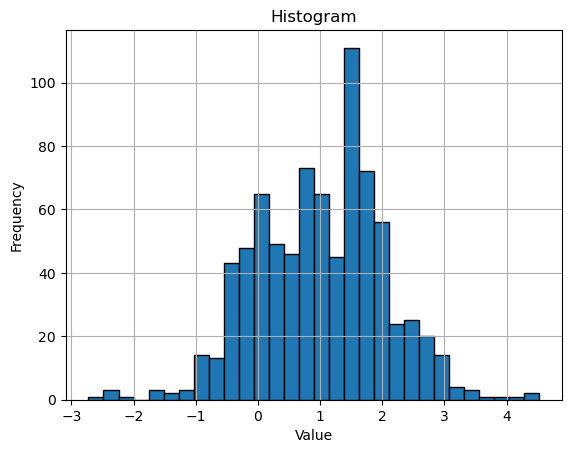

In [22]:

plt.hist(np.log(results.error), bins=30, edgecolor='black')
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
